![embedding_mapping.png](https://github.com/yandexdataschool/nlp_course/raw/master/resources/embedding_mapping.png)

## Homework: Un(semi)-supervised word translation learning

Homework based on [Conneau et al. 2018](https://arxiv.org/abs/1710.04087) article.

In the homework we offer you to train a mapping between Ukrainian word vectors and Russian word vectors just like in the first homework of the NLP course. But unlike the first homework this mapping will be build (almost) unsupervised: without parallel data (pairs of corresponding words in Ukrainian and Russian).

In [3]:
%env KERAS_BACKEND=tensorflow
%env CUDA_VISIBLE_DEVICES=2
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L
import numpy as np
import gensim

from IPython import display
from tqdm import tnrange
import matplotlib.pyplot as plt
%matplotlib inline

env: KERAS_BACKEND=tensorflow
env: CUDA_VISIBLE_DEVICES=2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
!wget https://www.dropbox.com/s/cnwyfbfa44mqxph/ukr_rus.train.txt?dl=1 -O ./ukr_rus.train.txt
!wget https://www.dropbox.com/s/78otz1d4d9b0284/ukr_rus.test.txt?dl=1 -O ./ukr_rus.test.txt
!wget https://www.dropbox.com/s/210m7gwqkikpsxd/uk.w2v.bin?dl=1 -O ./uk.w2v.bin
!wget https://www.dropbox.com/s/3luwyjdmofsdfjz/ru.w2v.bin?dl=1 -O ./ru.w2v.bin

--2018-12-17 20:10:30--  https://www.dropbox.com/s/cnwyfbfa44mqxph/ukr_rus.train.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6026:1::a27d:4601, 162.125.70.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6026:1::a27d:4601|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cnwyfbfa44mqxph/ukr_rus.train.txt [following]
--2018-12-17 20:10:31--  https://www.dropbox.com/s/dl/cnwyfbfa44mqxph/ukr_rus.train.txt
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceda4609294916a16cabdb435a0.dl.dropboxusercontent.com/cd/0/get/AXqmG-3iGvsD0XjCGUZo3fGeD8-rKqTo1WMmS8Ed--M2pE_AgBnPqFw_9n-VoKnLrVnO-Ksb7Lc5hXD7SmZnhX675ymKobd4OP5inrfaIaqIW_DBoNm5RdHIRoysB9LOkCRDc_L0HCAADVej2w7eT-MzJrcf-gUGLotABDrfYJRepS6hJ8POd_utdBLki9lfa5g/file?dl=1 [following]
--2018-12-17 20:10:31--  https://uceda4609294916a16cabdb435a0.dl.dropboxusercontent.com/cd/0/get/AXqmG-3iGvsD0Xj

In [5]:
ru_embs = gensim.models.KeyedVectors.load_word2vec_format("ru.w2v.bin", binary=True)
uk_embs = gensim.models.KeyedVectors.load_word2vec_format("uk.w2v.bin", binary=True)

In [6]:
x = uk_embs.vectors[:50000]
y = ru_embs.vectors[:50000]

In [7]:
def precision(pairs, uk_vectors, topn=1):
    """ TODO maybe insert docstring """
    assert len(pairs) == len(uk_vectors)
    num_matches = 0
    for i, (uk, ru) in enumerate(pairs):
        num_matches += ru in set(w[0] for w in ru_embs.most_similar([uk_vectors[i]], topn=topn))
    return num_matches / len(pairs)

def load_word_pairs(filename):
    uk_ru_pairs = []
    uk_vectors = []
    ru_vectors = []
    with open(filename, "r") as inpf:
        for line in inpf:
            uk, ru = line.rstrip().split("\t")
            if uk not in uk_embs or ru not in ru_embs:
                continue
            uk_ru_pairs.append((uk, ru))
            uk_vectors.append(uk_embs[uk])
            ru_vectors.append(ru_embs[ru])
    return uk_ru_pairs, np.array(uk_vectors), np.array(ru_vectors)

In [8]:
uk_ru_test, x_test, y_test = load_word_pairs("ukr_rus.test.txt")
uk_ru_train, x_train, y_train = load_word_pairs("ukr_rus.train.txt")

In [9]:
precision(uk_ru_test, x_test, 5)

/home/ya-philya/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.0

## Reminder

### Embedding space mapping

Let $x_i \in \mathrm{R}^d$ be the distributed representation of word $i$ in the source language, and $y_i \in \mathrm{R}^d$ is the vector representation of its translation. Our purpose is to learn such linear transform $W$ that minimizes euclidian distance between $Wx_i$ and $y_i$ for some subset of word embeddings. Thus we can formulate so-called Procrustes problem:

$$W^*= \arg\min_W \sum_{i=1}^n||Wx_i - y_i||_2$$
or
$$W^*= \arg\min_W ||WX - Y||_F$$

where $||*||_F$ - Frobenius norm.

In Greek mythology, Procrustes or "the stretcher" was a rogue smith and bandit from Attica who attacked people by stretching them or cutting off their legs, so as to force them to fit the size of an iron bed. We make same bad things with source embedding space. Our Procrustean bed is target embedding space.

But wait...$W^*= \arg\min_W \sum_{i=1}^n||Wx_i - y_i||_2$ looks like simple multiple linear regression (without intercept fit). So let's code.

### Orthogonal Procrustean Problem

It can be shown (see original paper) that a self-consistent linear mapping between semantic spaces should be orthogonal. TODO simplify phrases
We can restrict transform $W$ to be orthogonal. Then we will solve next problem:

$$W^*= \arg\min_W ||WX - Y||_F \text{, where: } W^TW = I$$

$$I \text{- identity matrix}$$

Instead of making yet another regression problem we can find optimal orthogonal transformation using singular value decomposition. It turns out that optimal transformation $W^*$ can be expressed via SVD components:
$$X^TY=U\Sigma V^T\text{, singular value decompostion}$$
$$W^*=UV^T$$

## Word translation learning using GAN (8 points)

### Generator

If $\mathcal{X}=\{x_1,...,x_n\} \subset \mathrm{R}^d$ - source embedding set, and $\mathcal{Y}=\{y_1,...,y_m\} \subset \mathrm{R}^d$ - target embedding set, then discriminator is simply orthogonal mapping that can be defined as square matrix: $W\in O_d(\mathrm{R})$.

In terms of neural network, generator is a network with single linear layer with orthogonality constraint and without nonlinearity after it.

The generator input is a source embedding $x_i$, the generator output is a mapped source embedding $Wx_i$

In [10]:
EMB_SIZE = 300

In [11]:
import keras, keras.layers as L

def build_generator(emb_size):
    model = Sequential()
    model.add(L.Dense(emb_size, activation=None, use_bias=False, kernel_initializer=keras.initializers.Identity(), 
                     input_shape=[emb_size]))
    # TIPS: use keras.Sequential and keras.initializers
    # YOUR_CODE
    return model

In [51]:
generator = build_generator(EMB_SIZE)

### Discriminator

Discriminator is a neural network that should discriminate between objects from $W\mathcal{X}$ (mapped source embeddings) and objects from $\mathcal{Y}$ (target embeddings).

Just like in original article for discriminator we will use a multilayer perceptron with two hidden layers of size 2048, and Leaky-ReLU activation functions. The input to the discriminator is corrupted with dropout noise
with a rate of 0.1.

The discriminator input is either mapped source embedding $Wx_i$ or target embedding $y_j$, the discriminator output is a probability of input to be from source distribution $p_D=p_D(source=1)$



In [15]:
def build_discriminator(emb_size):
    # YOUR_CODE
    model = Sequential()
    model.add(L.InputLayer([emb_size]))
    model.add(L.Dense(2048, activation=None))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dense(2048, activation=None))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dense(1, activation=None))
    return model

In [16]:
discriminator = build_discriminator(EMB_SIZE)

### Discriminator loss

The purpose of discriminator is to maximize output probability for mapped source embeddings $p_D(source=1|Wx_i)$ and minimize probability for target embeddings $p_D(source=1|y_j)$. The last is equivalent to maximization of  $p_D(source=0|y_j)$. Thus, we can train this classifier with standard cross-entropy loss:

$$\mathcal{L}_D(\theta_D|W)=-\frac{1}{n}\sum_{i=1}^n\log p_D(source=1|Wx_i)-\frac{1}{m}\sum_{i=1}^m\log p_D(source=0|y_i)$$
Equivalent:
$$\mathcal{L}_D(\theta_D|W)=-\frac{1}{n}\sum_{i=1}^n\log p_D(source=1|Wx_i)-\frac{1}{m}\sum_{i=1}^m\log (1-p_D(source=1|y_i))$$

**NB:** We minimize $\mathcal{L}_D(\theta_D|W)$ with respect discriminator parameters $\theta_D$. The matrix $W$ is fixed.

In [17]:
# YOUR_CODE HERE

X = tf.placeholder(tf.float32, [None, EMB_SIZE])
Y = tf.placeholder(tf.float32, [None, EMB_SIZE])
W = generator.weights[0]
WX = generator(X)

In [18]:
desc_wx = discriminator(WX)
logp_wx_is_real = tf.log_sigmoid(desc_wx)
logp_wx_is_fake = tf.log_sigmoid(-desc_wx)
logp_y_is_real = tf.log_sigmoid(discriminator(Y))

L_d_source = -tf.reduce_mean(logp_wx_is_fake)
L_d_target = -tf.reduce_mean(logp_y_is_real)
L_d = L_d_source + L_d_target

As suggested Goodfellow (2016) it is useful to use soft targets instead hard ones. In case label smoothing:
$$\mathcal{L}_D(\theta_D|W)=\mathcal{L}_{D_1}+\mathcal{L}_{D_2}$$

Where:
$$\mathcal{L}_{D_1}=\frac{1}{n}\sum_{i=1}^n[(1-\alpha)\log p_D(source=1|Wx_i) + \alpha\log p_D(source=0|Wx_i)]$$

$$\mathcal{L}_{D_2}=\frac{1}{m}\sum_{i=1}^n[(1-\alpha)\log p_D(source=0|Wx_i) + \alpha\log p_D(source=1|Wx_i)]$$

In [ ]:
# YOUR CODE HERE IF YOU REALLY WANT TO USE LABEL SMOOTHING

### Generator loss

The purpose of generator is to fool discriminator, i.e. to produce mapping $W\mathcal{X}$ indistinguishable from $\mathcal{Y}$. Therefore we should turn over discriminator loss, minimize output probability for mapped source embeddings $p_D(source=1|Wx_i)$ and minimize probability for target embeddings $p_D(source=0|y_j)$.

$$\mathcal{L}_G(W|\theta_D)=-\frac{1}{n}\sum_{i=1}^n\log (1-p_D(source=1|Wx_i))-\frac{1}{m}\sum_{i=1}^m\log p_D(source=1|y_i)$$

**NB:** We minimize $\mathcal{L}_G(W|\theta_D)$ with respect matrix $W$ coefficients. Disciminator parameters $\theta_D$ is fixed.

Because gradients do not flow through generator for target samples:

$$\mathcal{L}_G(W|\theta_D)=-\frac{1}{n}\sum_{i=1}^n\log (1-p_D(source=1|Wx_i))$$

In contrast with original article to be more stable we allow you to add a supervised component of loss - MSE for small number of fixed pairs vectors from $\mathcal{X}$ and $\mathcal{Y}$.

$$\mathcal{L}_G(W|\theta_D)=-\frac{1}{n}\sum_{i=1}^n\log (1-p_D(source=1|Wx_i))+\gamma \frac{1}{N}\sum_{k}^N(Wx_k-y_k)^2$$

In [19]:
X_pair = tf.placeholder('float32', [None, EMB_SIZE])
Y_pair = tf.placeholder('float32', [None, EMB_SIZE])

# YOUR_CODE_HERE

L_g_source = -tf.reduce_mean(logp_wx_is_real)
L_mse = tf.losses.mean_squared_error(Y_pair, generator(X_pair))

L_g = L_mse * 100 + L_g_source

### Orthogonality constraint
Conneau et al. propose to use a simple update step to ensure that the matrix $W$ stays close to an
orthogonal matrix during training:

$$W \gets (1+\beta)W-\beta(WW^T)W$$

In [20]:
BETA = tf.constant(0.1)

W_new = (1 + BETA) * W - BETA * tf.matmul(tf.matmul(W, W, transpose_b=True), W)
# TIPS: USE tf.assing
orthogonolize = tf.assign(W, W_new)

### Training

In [21]:
LEARNING_RATE = 0.1
# GRADIENT DESCENT OPTIMIZER?

gen_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_g, var_list=generator.trainable_weights)
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_d, var_list=discriminator.trainable_weights)

In [22]:
BATCH_SIZE = 128

def sample_batch(bsize):
    x_batch = x[np.random.choice(np.arange(x.shape[0]), size=bsize)]
    y_batch = y[np.random.choice(np.arange(y.shape[0]), size=bsize)]
    return x_batch, y_batch

In [23]:
def discriminator_step():
    # YOUR_CODE
    feed_dict = {
        X: x_batch,
        Y: y_batch
    }
    sess.run(dis_optim, feed_dict)
    
def generator_step():
    # YOUR_CODE
    feed_dict = {
        X: x_batch,
        X_pair: x_train[:50],
        Y_pair: y_train[:50]
    }
    sess.run(gen_optim, feed_dict)

def orthogonolize_step():
    sess.run(orthogonolize)



In [24]:
def get_metrics():
    feed_dict = {
        X: x_test,
        Y: y_test,
        X_pair: x_train[:50],
        Y_pair: y_train[:50]
    }
    loss_g, loss_d, logp_x, logp_y, wx = sess.run([L_g, L_d, logp_wx_is_real, logp_y_is_real, WX], feed_dict)
    return loss_g, loss_d, np.exp(logp_x), np.exp(logp_y), wx

In [25]:
sess = keras.backend.get_session()
sess.run(tf.global_variables_initializer())

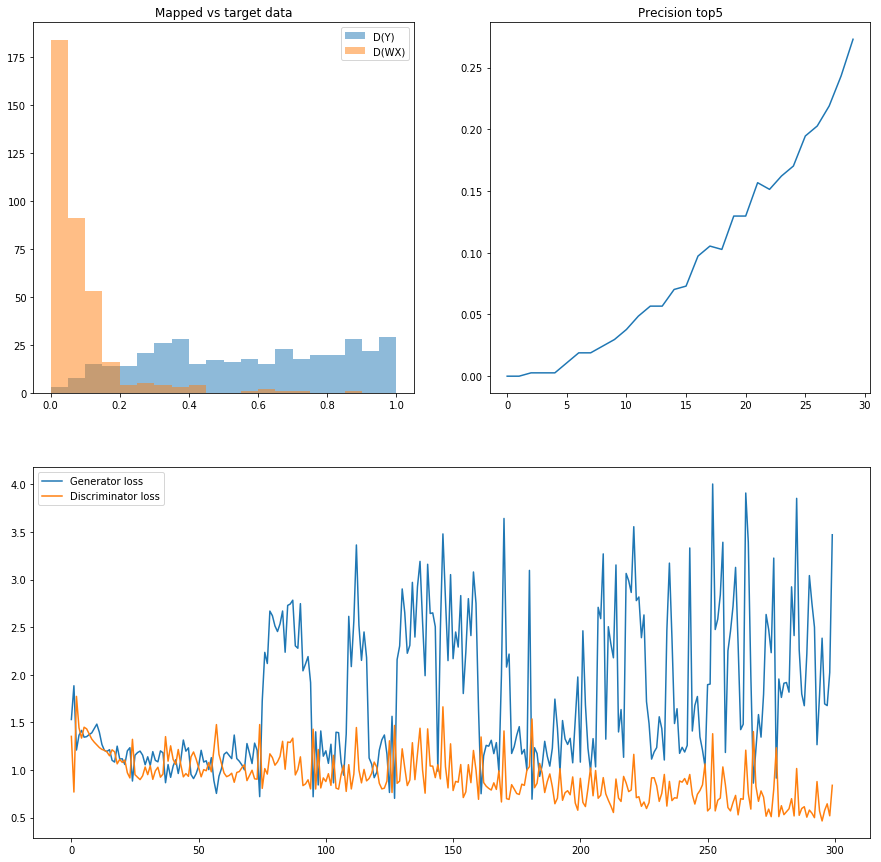

In [26]:
N_EPOCHS = 10
EPOCH_SIZE = 300
DIS_STEPS = 5
GEN_STEPS = 1


gen_loss_history = []
dis_loss_history = []
prec_history = []

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tnrange(EPOCH_SIZE):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
                
        

In [27]:
from tqdm import tqdm

Epoch: 3


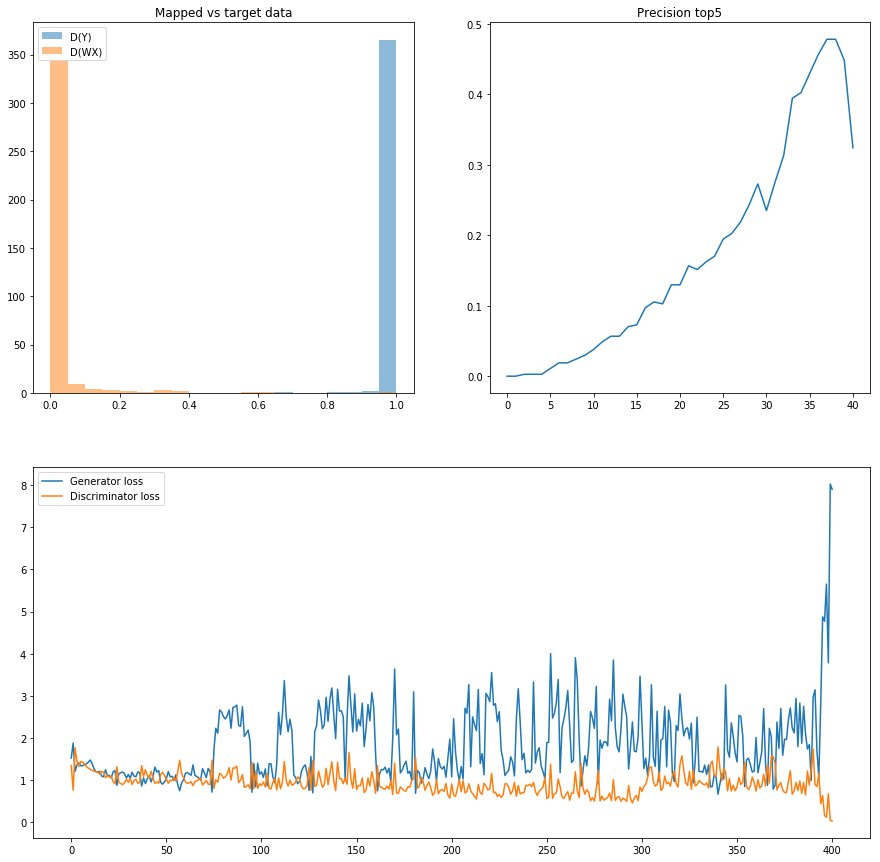

  2%|▏         | 8/500 [00:08<07:21,  1.11it/s]


KeyboardInterrupt: 

In [28]:
N_EPOCHS = 10
EPOCH_SIZE = 500
DIS_STEPS = 5
GEN_STEPS = 5

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE)):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
                
        

In [32]:
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE / 10).minimize(L_d, var_list=discriminator.trainable_weights)

Epoch: 3


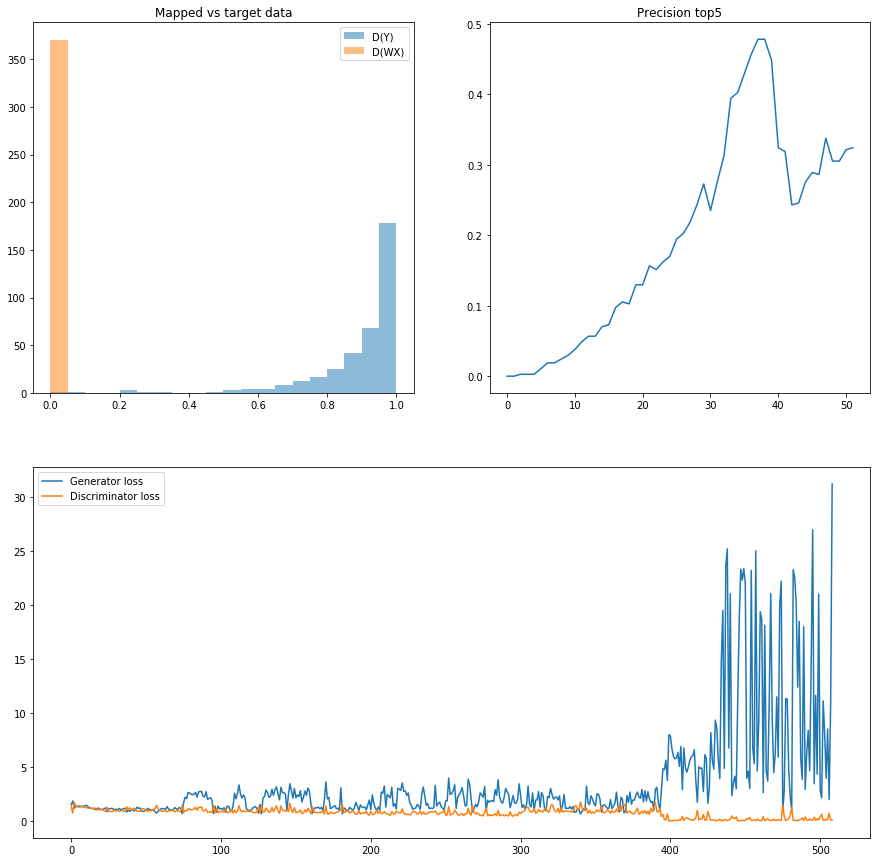

 14%|█▍        | 71/500 [00:25<02:59,  2.39it/s]

KeyboardInterrupt: 

In [33]:
N_EPOCHS = 10
EPOCH_SIZE = 500
DIS_STEPS = 1
GEN_STEPS = 5

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE)):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
                
        

In [34]:
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE / 100).minimize(L_d, var_list=discriminator.trainable_weights)

Epoch: 2


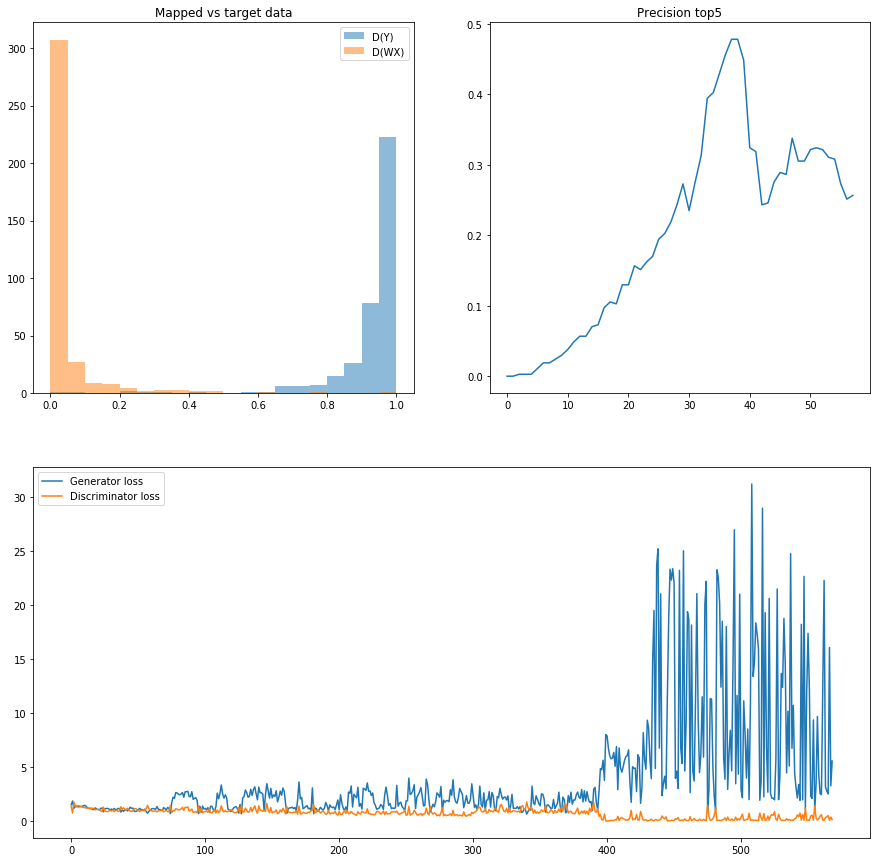


 19%|█▊        | 93/500 [00:37<02:38,  2.56it/s]

KeyboardInterrupt: 

In [35]:
N_EPOCHS = 10
EPOCH_SIZE = 500
DIS_STEPS = 1
GEN_STEPS = 7

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE)):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
                
        

In [36]:
gen_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE / 10).minimize(L_g, var_list=generator.trainable_weights)
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE / 1000).minimize(L_d, var_list=discriminator.trainable_weights)

Epoch: 10


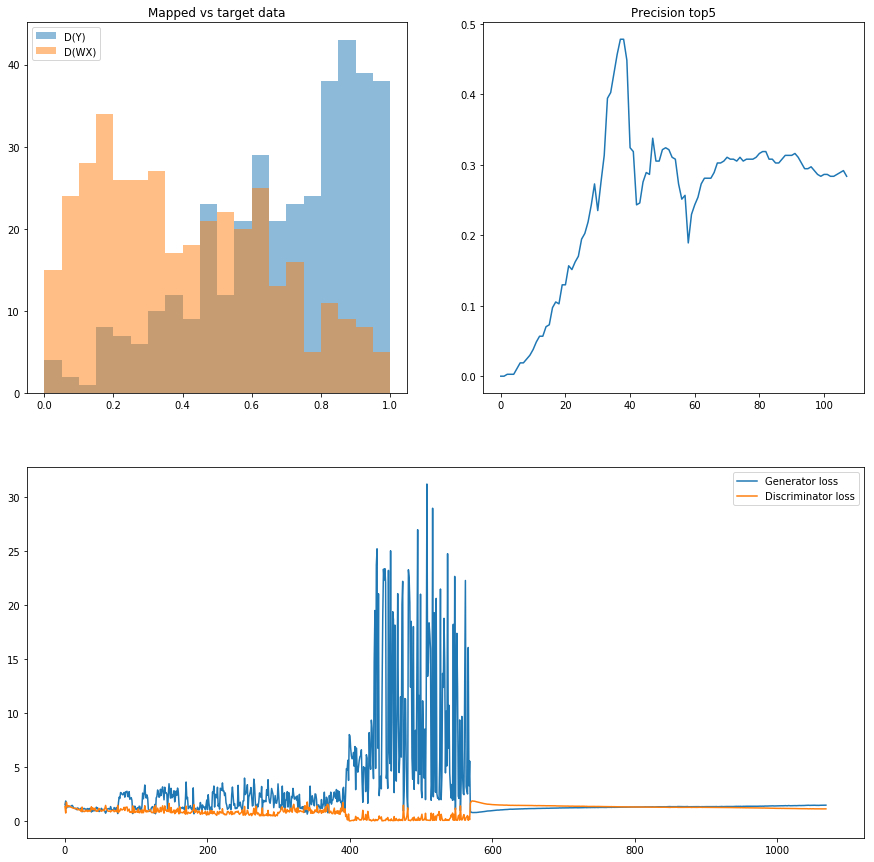



 98%|█████████▊| 491/500 [13:40<00:04,  2.02it/s]

 98%|█████████▊| 492/500 [13:41<00:03,  2.20it/s]

 99%|█████████▊| 493/500 [13:41<00:02,  2.36it/s]

 99%|█████████▉| 494/500 [13:41<00:02,  2.48it/s]

 99%|█████████▉| 495/500 [13:42<00:01,  2.57it/s]

 99%|█████████▉| 496/500 [13:42<00:01,  2.64it/s]

 99%|█████████▉| 497/500 [13:43<00:01,  2.70it/s]

100%|█████████▉| 498/500 [13:43<00:00,  2.74it/s]

100%|█████████▉| 499/500 [13:43<00:00,  2.77it/s]

100%|██████████| 500/500 [13:44<00:00,  2.80it/s]



In [37]:
N_EPOCHS = 10
EPOCH_SIZE = 500
DIS_STEPS = 1
GEN_STEPS = 10

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE)):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
                
        

Ну в общем в какой-то момент что-то пошло не так

Попробуем еще раз


In [44]:
LEARNING_RATE = 0.1
# GRADIENT DESCENT OPTIMIZER?

gen_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_g, var_list=generator.trainable_weights)
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_d, var_list=discriminator.trainable_weights)

In [45]:
sess.run(tf.global_variables_initializer())

gen_loss_history = []
dis_loss_history = []
prec_history = []

Epoch: 30


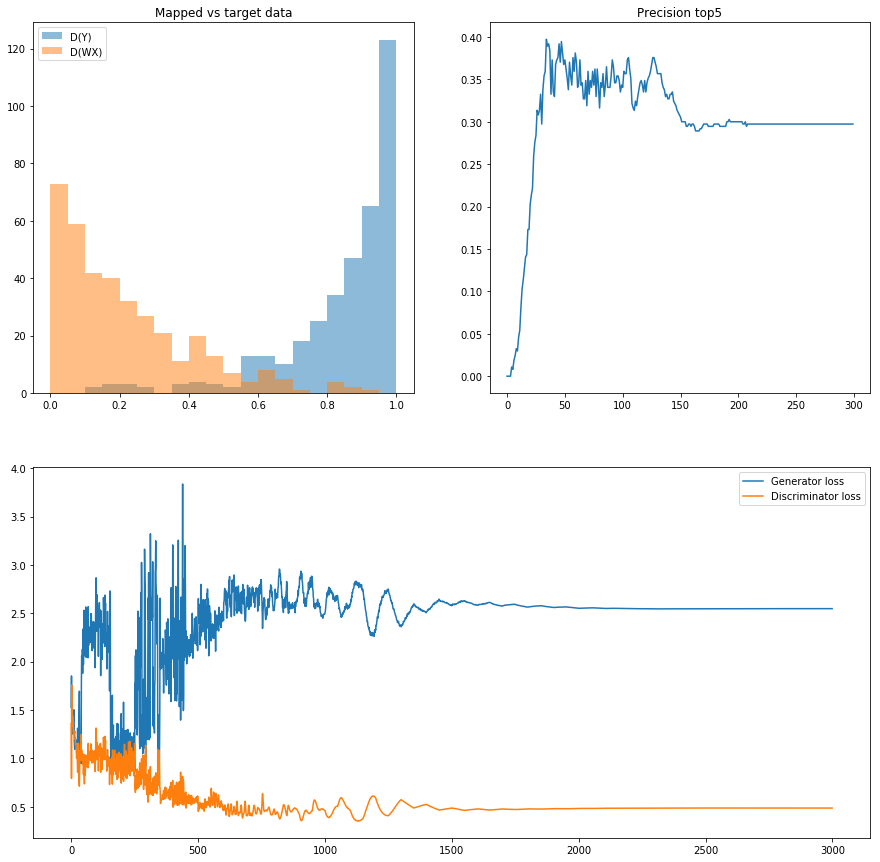






 99%|█████████▉| 991/1000 [21:01<00:12,  1.35s/it]




 99%|█████████▉| 992/1000 [21:02<00:10,  1.30s/it]




 99%|█████████▉| 993/1000 [21:04<00:08,  1.27s/it]




 99%|█████████▉| 994/1000 [21:05<00:07,  1.24s/it]




100%|█████████▉| 995/1000 [21:06<00:06,  1.23s/it]




100%|█████████▉| 996/1000 [21:07<00:04,  1.22s/it]




100%|█████████▉| 997/1000 [21:08<00:03,  1.21s/it]




100%|█████████▉| 998/1000 [21:10<00:02,  1.21s/it]




100%|█████████▉| 999/1000 [21:11<00:01,  1.20s/it]




100%|██████████| 1000/1000 [21:12<00:00,  1.20s/it]






In [46]:
N_EPOCHS = 30
EPOCH_SIZE = 1000
DIS_STEPS = 5
GEN_STEPS = 1
GEN_LR = LEARNING_RATE
DIS_LR = LEARNING_RATE

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE)):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        if batch_num == EPOCH_SIZE // 2:
            DIS_LR /= 1.8
            dis_optim = tf.train.GradientDescentOptimizer(DIS_LR).minimize(L_d, 
                                                                           var_list=discriminator.trainable_weights)
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
    GEN_LR /= 1.8
    gen_optim = tf.train.GradientDescentOptimizer(GEN_LR).minimize(L_g, 
                                                                   var_list=generator.trainable_weights)
    GEN_STEPS += 1
    
                
        

In [47]:
GEN_LR, DIS_LR

(2.1969736438175396e-09, 2.1969736438175396e-09)

In [48]:
GEN_STEPS

31

In [49]:
np.max(prec_history)

0.3972972972972973

попробуем с дропаутом

In [70]:
def build_discriminator(emb_size):
    # YOUR_CODE
    model = Sequential()
    model.add(L.InputLayer([emb_size]))
    model.add(L.Dropout(rate=0.1))
    model.add(L.Dense(2048, activation=None))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dense(2048, activation=None))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dense(1, activation=None))
    return model

In [71]:
generator = build_generator(EMB_SIZE)

In [72]:
discriminator = build_discriminator(EMB_SIZE)

In [73]:
# YOUR_CODE HERE

X = tf.placeholder(tf.float32, [None, EMB_SIZE])
Y = tf.placeholder(tf.float32, [None, EMB_SIZE])
W = generator.weights[0]
WX = generator(X)

In [74]:
desc_wx = discriminator(WX)
logp_wx_is_real = tf.log_sigmoid(desc_wx)
logp_wx_is_fake = tf.log_sigmoid(-desc_wx)
logp_y_is_real = tf.log_sigmoid(discriminator(Y))

L_d_source = -tf.reduce_mean(logp_wx_is_fake)
L_d_target = -tf.reduce_mean(logp_y_is_real)
L_d = L_d_source + L_d_target

In [75]:
X_pair = tf.placeholder('float32', [None, EMB_SIZE])
Y_pair = tf.placeholder('float32', [None, EMB_SIZE])

# YOUR_CODE_HERE

L_g_source = -tf.reduce_mean(logp_wx_is_real)
L_mse = tf.losses.mean_squared_error(Y_pair, generator(X_pair))

L_g = L_mse * 100 + L_g_source

In [76]:
BETA = tf.constant(0.1)

W_new = (1 + BETA) * W - BETA * tf.matmul(tf.matmul(W, W, transpose_b=True), W)
# TIPS: USE tf.assing
orthogonolize = tf.assign(W, W_new)

In [77]:
LEARNING_RATE = 0.1
# GRADIENT DESCENT OPTIMIZER?

gen_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_g, var_list=generator.trainable_weights)
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_d, var_list=discriminator.trainable_weights)

In [78]:
sess = keras.backend.get_session()
sess.run(tf.global_variables_initializer())
gen_loss_history = []
dis_loss_history = []
prec_history = []

In [79]:
def get_metrics():
    feed_dict = {
        X: x_test,
        Y: y_test,
        X_pair: x_train[:50],
        Y_pair: y_train[:50]
    }
    loss_g, loss_d, logp_x, logp_y, wx = sess.run([L_g, L_d, logp_wx_is_real, logp_y_is_real, WX], feed_dict)
    wx = generator.predict(x_test)
    return loss_g, loss_d, np.exp(logp_x), np.exp(logp_y), wx

In [80]:
def discriminator_step():
    # YOUR_CODE
    feed_dict = {
        X: x_batch,
        Y: y_batch
    }
    sess.run(dis_optim, feed_dict)
    
def generator_step():
    # YOUR_CODE
    feed_dict = {
        X: x_batch,
        X_pair: x_train[:50],
        Y_pair: y_train[:50]
    }
    sess.run(gen_optim, feed_dict)

def orthogonolize_step():
    sess.run(orthogonolize)



Epoch: 12


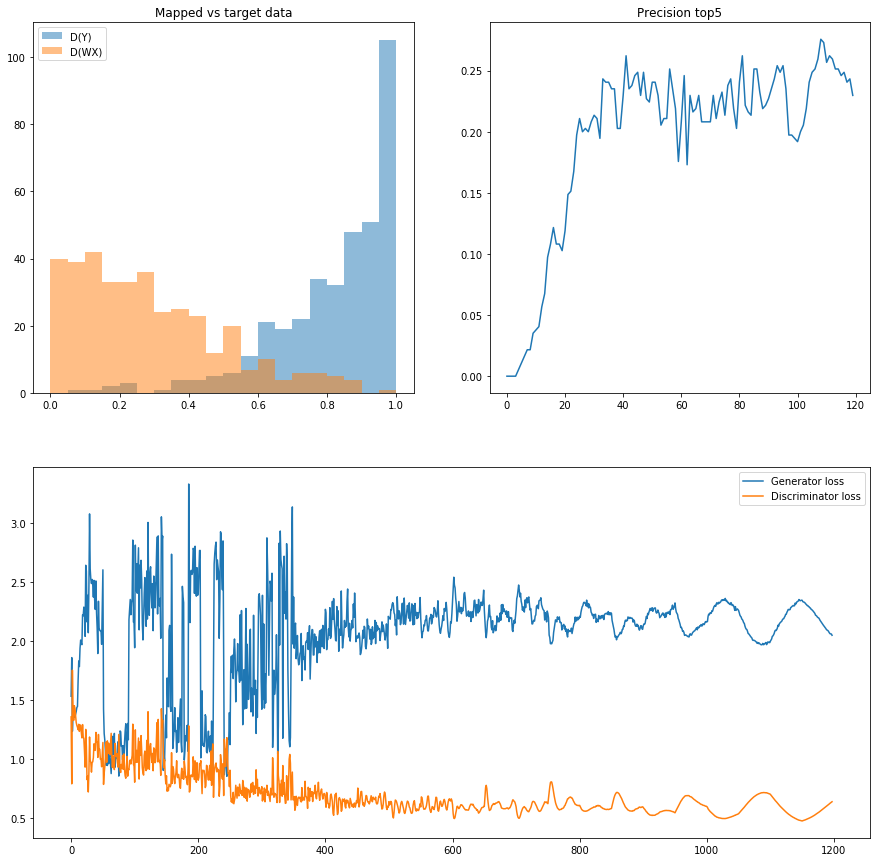










 97%|█████████▋| 971/1000 [12:30<00:24,  1.17it/s]








 97%|█████████▋| 972/1000 [12:31<00:22,  1.24it/s]








 97%|█████████▋| 973/1000 [12:32<00:20,  1.29it/s]








 97%|█████████▋| 974/1000 [12:32<00:19,  1.33it/s]








 98%|█████████▊| 975/1000 [12:33<00:18,  1.36it/s]








 98%|█████████▊| 976/1000 [12:34<00:17,  1.39it/s]

KeyboardInterrupt: 

In [81]:
N_EPOCHS = 15
EPOCH_SIZE = 1000
DIS_STEPS = 5
GEN_STEPS = 1
GEN_LR = LEARNING_RATE
DIS_LR = LEARNING_RATE

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE)):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        if batch_num == EPOCH_SIZE // 2:
            DIS_LR /= 2.0
            dis_optim = tf.train.GradientDescentOptimizer(DIS_LR).minimize(L_d, 
                                                                           var_list=discriminator.trainable_weights)
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
    GEN_LR /= 1.8
    gen_optim = tf.train.GradientDescentOptimizer(GEN_LR).minimize(L_g, 
                                                                   var_list=generator.trainable_weights)
    GEN_STEPS += 1
    
                
        

Чет ниче не работает(

In [82]:
LEARNING_RATE = 0.05
# GRADIENT DESCENT OPTIMIZER?

gen_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_g, var_list=generator.trainable_weights)
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_d, var_list=discriminator.trainable_weights)

In [83]:
sess = keras.backend.get_session()
sess.run(tf.global_variables_initializer())
gen_loss_history = []
dis_loss_history = []
prec_history = []

Epoch: 15


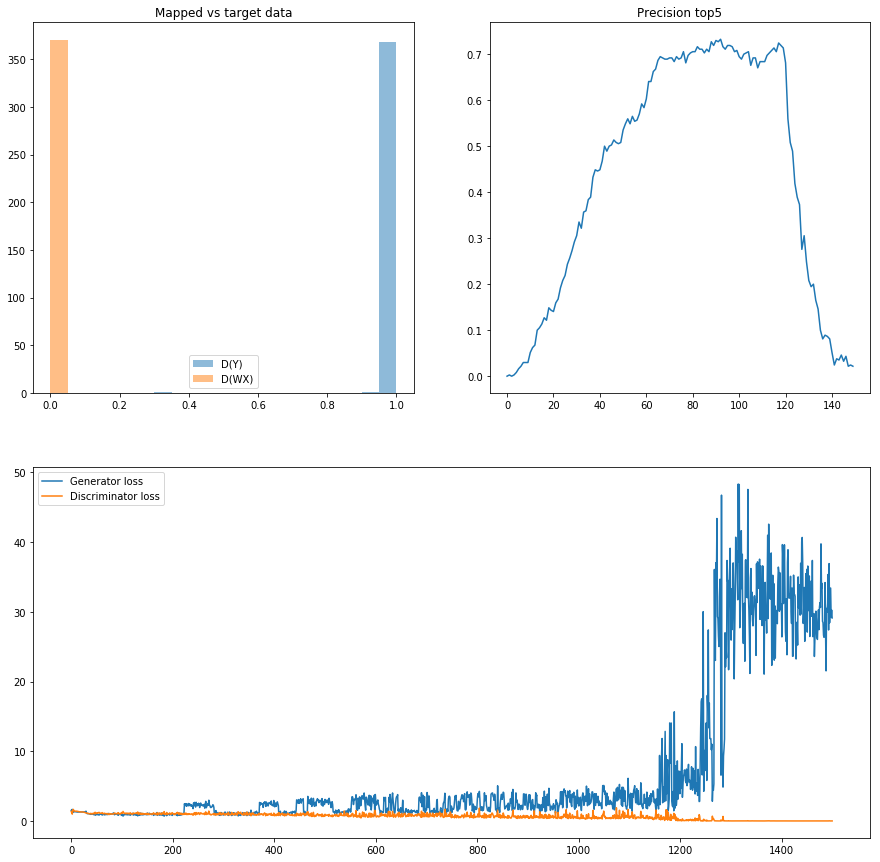











 99%|█████████▉| 991/1000 [08:33<00:05,  1.67it/s]









 99%|█████████▉| 992/1000 [08:34<00:04,  1.81it/s]









 99%|█████████▉| 993/1000 [08:34<00:03,  1.93it/s]









 99%|█████████▉| 994/1000 [08:35<00:02,  2.03it/s]









100%|█████████▉| 995/1000 [08:35<00:02,  2.10it/s]









100%|█████████▉| 996/1000 [08:36<00:01,  2.15it/s]









100%|█████████▉| 997/1000 [08:36<00:01,  2.19it/s]









100%|█████████▉| 998/1000 [08:37<00:00,  2.22it/s]









100%|█████████▉| 999/1000 [08:37<00:00,  2.24it/s]









100%|██████████| 1000/1000 [08:37<00:00,  2.25it/s]











In [84]:
N_EPOCHS = 15
EPOCH_SIZE = 1000
DIS_STEPS = 5
GEN_STEPS = 3
# GEN_LR = LEARNING_RATE
# DIS_LR = LEARNING_RATE

for epoch_num in range(N_EPOCHS):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE)):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
#         if batch_num == EPOCH_SIZE // 2:
#             DIS_LR /= 2.0
#             dis_optim = tf.train.GradientDescentOptimizer(DIS_LR).minimize(L_d, 
#                                                                            var_list=discriminator.trainable_weights)
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
#     GEN_LR /= 1.8
#     gen_optim = tf.train.GradientDescentOptimizer(GEN_LR).minimize(L_g, 
#                                                                    var_list=generator.trainable_weights)
#     GEN_STEPS += 1
    
                
        

In [85]:
np.max(prec_history)

0.7324324324324324

## Fully unsupervised word translation learning (2 points)

Try to exclude MSE term from generator loss and train GAN with sufficient quality (~40% precision top5). You should tune parameters of optimizers and training schedule to make it stable.

Good luck!

In [52]:
generator = build_generator(EMB_SIZE)

In [53]:
def build_discriminator(emb_size):
    # YOUR_CODE
    model = Sequential()
    model.add(L.InputLayer([emb_size]))
    model.add(L.Dropout(rate=0.1))
    model.add(L.Dense(2048, activation=None))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dense(2048, activation=None))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dense(1, activation=None))
    return model

In [54]:
discriminator = build_discriminator(EMB_SIZE)

In [55]:
# YOUR_CODE HERE

X = tf.placeholder(tf.float32, [None, EMB_SIZE])
Y = tf.placeholder(tf.float32, [None, EMB_SIZE])
W = generator.weights[0]
WX = generator(X)

In [56]:
desc_wx = discriminator(WX)
logp_wx_is_real = tf.log_sigmoid(desc_wx)
logp_wx_is_fake = tf.log_sigmoid(-desc_wx)
logp_y_is_real = tf.log_sigmoid(discriminator(Y))

L_d_source = -tf.reduce_mean(logp_wx_is_fake)
L_d_target = -tf.reduce_mean(logp_y_is_real)
L_d = L_d_source + L_d_target

In [57]:
# YOUR_CODE_HERE

L_g_source = -tf.reduce_mean(logp_wx_is_real)

L_g = L_g_source

In [58]:
BETA = tf.constant(0.1)

W_new = (1 + BETA) * W - BETA * tf.matmul(tf.matmul(W, W, transpose_b=True), W)
# TIPS: USE tf.assing
orthogonolize = tf.assign(W, W_new)

In [59]:
LEARNING_RATE = 0.1
# GRADIENT DESCENT OPTIMIZER?

gen_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_g, var_list=generator.trainable_weights)
dis_optim = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(L_d, var_list=discriminator.trainable_weights)

In [60]:
BATCH_SIZE = 128

def sample_batch(bsize):
    x_batch = x[np.random.choice(np.arange(x.shape[0]), size=bsize)]
    y_batch = y[np.random.choice(np.arange(y.shape[0]), size=bsize)]
    return x_batch, y_batch

In [61]:
def discriminator_step():
    # YOUR_CODE
    feed_dict = {
        X: x_batch,
        Y: y_batch
    }
    sess.run(dis_optim, feed_dict)
    
def generator_step():
    # YOUR_CODE
    feed_dict = {
        X: x_batch
    }
    sess.run(gen_optim, feed_dict)

def orthogonolize_step():
    sess.run(orthogonolize)



In [66]:
def get_metrics():
    feed_dict = {
        X: x_test,
        Y: y_test
    }
    loss_g, loss_d, logp_x, logp_y, wx = sess.run([L_g, L_d, logp_wx_is_real, logp_y_is_real, WX], feed_dict)
    wx = generator.predict(x_test, batch_size=128)
    return loss_g, loss_d, np.exp(logp_x), np.exp(logp_y), wx

In [67]:
sess = keras.backend.get_session()
sess.run(tf.global_variables_initializer())
gen_loss_history = []
dis_loss_history = []
prec_history = []

Epoch: 9


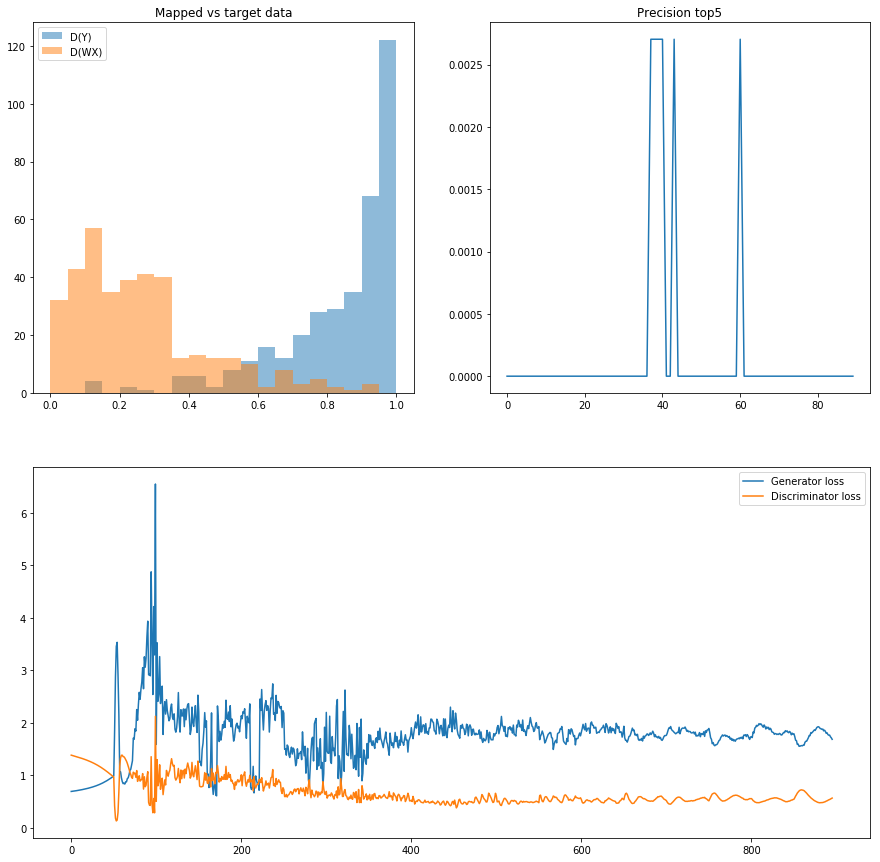









 95%|█████████▌| 951/1000 [10:52<00:36,  1.33it/s]







 95%|█████████▌| 952/1000 [10:53<00:34,  1.41it/s]







 95%|█████████▌| 953/1000 [10:53<00:31,  1.48it/s]

KeyboardInterrupt: 

In [68]:
N_EPOCHS = 15
EPOCH_SIZE = 1000
DIS_STEPS = 5
GEN_STEPS = 1
GEN_LR = LEARNING_RATE
DIS_LR = LEARNING_RATE

for epoch_num in tqdm(range(N_EPOCHS)):
    print("Epoch: {}".format(epoch_num + 1))
    for batch_num in tqdm(range(EPOCH_SIZE), leave=False):
        
        for _ in range(DIS_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            discriminator_step()
            
        for _ in range(GEN_STEPS):
            # YOUR_CODE
            x_batch, y_batch = sample_batch(BATCH_SIZE)
            generator_step()
            orthogonolize_step()
        if batch_num == EPOCH_SIZE // 2:
            DIS_LR /= 2
            dis_optim = tf.train.GradientDescentOptimizer(DIS_LR).minimize(L_d, 
                                                                           var_list=discriminator.trainable_weights)
        if batch_num % 10 == 0:
            display.clear_output(wait=True)
            print("Epoch: {}".format(epoch_num + 1))
            loss_g, loss_d, p_x, p_y, wx = get_metrics()
            gen_loss_history.append(loss_g)
            dis_loss_history.append(loss_d)
            
            if batch_num % 100 == 0:
                prec_history.append(precision(uk_ru_test, wx, 5))

            plt.figure(figsize=(15,15))
            plt.subplot(212)
            plt.plot(gen_loss_history, label="Generator loss")
            plt.plot(dis_loss_history, label="Discriminator loss")
            plt.legend(loc='best')

            plt.subplot(221)
            plt.title('Mapped vs target data')
            plt.hist(p_y, label='D(Y)', alpha=0.5,range=[0,1], bins=20)
            plt.hist(p_x, label='D(WX)',alpha=0.5,range=[0,1], bins=20)
            plt.legend(loc='best')
            
            plt.subplot(222)
            plt.title('Precision top5')
            plt.plot(prec_history)
            plt.show()
    GEN_LR /= 1.8
    gen_optim = tf.train.GradientDescentOptimizer(GEN_LR).minimize(L_g, 
                                                                   var_list=generator.trainable_weights)
    GEN_STEPS += 1
    
                
        

Чет не заработало
